In [ ]:
!nvidia-smi

Sun Dec  4 16:04:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    31W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders
import os
#os.mkdir(r"C:\rafid\augmentation\covid\covid aug\photometric")

input_folder="/content/drive/MyDrive/rhd_model/Furier_transform"


output="/content/"



splitfolders.ratio(input_folder, output, seed=42, ratio=(.8,.1,.1)) ### train 80%, val 10%, test 20%


Copying files: 5882 files [03:45, 26.10 files/s] 


In [ ]:
pip install keras_applications==1.0.4 --no-deps

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.4 MB/s 


In [ ]:
#Soft Attention

from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf



class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x


        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC

        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]

        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape


        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))


        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1)
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)


        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))

            x_exp = K.expand_dims(x,axis=-2)

            u = kl.Multiply()([exp_softmax_alpha, x_exp])

            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u

        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape):
        return [self.out_features_shape, self.out_attention_maps_shape]


    def get_config(self):
        return super(SoftAttention,self).get_config()


In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers

model = Sequential()
inputs = Input(shape=(224, 224, 3))
model = Conv2D(32, kernel_size=(3, 3), strides=2, padding="same", activation="relu")(inputs)
model = MaxPooling2D(pool_size=(2, 2))(model)
model = Conv2D(64, kernel_size=(3, 3), strides=2, padding="same", activation="relu")(model)
model = MaxPooling2D(pool_size=(2, 2))(model)
model = Conv2D(64, kernel_size=(3, 3), strides=2, padding="same", activation="relu")(model)
model = MaxPooling2D(pool_size=(2, 2))(model)
model = MaxPooling2D(pool_size=(2, 2))(model)





In [ ]:
# model = tf.keras.applications.model(
#     include_top=True,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=None,
#     pooling=None,

# )
# # Exclude the last 28 layers of the model.
#conv = mobilenet.layers[-8].output

In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,BatchNormalization,Dropout
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(model.shape[-1]),name='soft_attention')(model)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(model))

conv = concatenate([conv,attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)


output = Flatten()(conv)
output = Reshape(target_shape=(16, 8))(output)
output = LSTM(128, activation="tanh")(output)
output = Dense(4, activation='softmax')(output)
model = Model(inputs=inputs, outputs=output)


In [ ]:
model.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_42 (Conv2D)             (None, 112, 112, 32  896         ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 max_pooling2d_137 (MaxPooling2  (None, 56, 56, 32)  0           ['conv2d_42[0][0]']              
 D)                                                                                        

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
#from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
#from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from tensorflow import keras
import numpy as np
from glob import glob
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

IMAGE_SIZE = [224,224]

In [ ]:
# sayma comment out line 2, Ritu comment out line 1 before running

op = keras.optimizers.Nadam(learning_rate=0.0007,epsilon=0.1)  #for Sayma
#op = keras.optimizers.Nadam(lr=0.0007)  # for Ritu
model.compile(
  loss='categorical_crossentropy',
  optimizer=op,
  metrics=['accuracy']
)

In [ ]:

train_datagen = ImageDataGenerator(rescale = 1./255,
                                  # shear_range = 0.2,
                                  # zoom_range = 0.2,
                                   brightness_range=(0.4, 0.7),
                                   vertical_flip= True,
                                   horizontal_flip = True)

val_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/train',
                                                 target_size = (224,224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

val_set = val_datagen.flow_from_directory('/content/val',
                                            target_size = (224,224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_directory('/content/test',
                                            target_size = (224,224),
                                            batch_size = 1,
                                            class_mode = 'categorical')



model.optimizer.get_config()

Found 4704 images belonging to 4 classes.
Found 587 images belonging to 4 classes.
Found 591 images belonging to 4 classes.


{'name': 'Nadam',
 'learning_rate': 0.0007,
 'decay': 0.004,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 0.1}

In [ ]:
from PIL import Image

filepath = r"/content/drive/MyDrive/mobilenet2/h5/mobilenetv2_SE_.h5"

### example___filepath = "path to weight directory/breastCancer_geometric.h5"


checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,save_weights_only=True,
                             save_best_only=True, mode='max')

log_csv = CSVLogger(r'/content/drive/MyDrive/mobilenet2/csv/mobilenetv2_SE_.csv', separator=',', append=False)
### example___CSVLogger('path to logs directory/breastCancer_geometric.csv')

callbacks_list = [checkpoint1,log_csv]


r = model.fit_generator(
    training_set,
    epochs=100,
    validation_data=val_set,
    steps_per_epoch = len(training_set),
    validation_steps=len(val_set),
    callbacks=callbacks_list,
    shuffle=False


)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/100
102/102 [==============================] - ETA: 0s - loss: 0.5517 - accuracy: 0.8472
Epoch 1: val_accuracy improved from -inf to 0.70464, saving model to /content/drive/MyDrive/mobilenet2/h5/mobilenetv2_SE_.h5
102/102 [==============================] - 120s 668ms/step - loss: 0.5517 - accuracy: 0.8472 - val_loss: 1.8051 - val_accuracy: 0.7046
Epoch 2/100
102/102 [==============================] - ETA: 0s - loss: 0.0841 - accuracy: 0.9729
Epoch 2: val_accuracy improved from 0.70464 to 0.90577, saving model to /content/drive/MyDrive/mobilenet2/h5/mobilenetv2_SE_.h5
102/102 [==============================] - 40s 392ms/step - loss: 0.0841 - accuracy: 0.9729 - val_loss: 0.2731 - val_accuracy: 0.9058
Epoch 3/100
102/102 [==============================] - ETA: 0s - loss: 0.0602 - accuracy: 0.9778
Epoch 3: val_accuracy did not improve from 0.90577
102/102 [==============================] - 39s 379ms/step - loss: 0.0602 - accuracy: 0.9778 - val_loss: 0.3761 - val_accuracy: 0.8959
Ep

In [ ]:
from PIL import Image

filepath = r"/content/drive/MyDrive/rhd_model/h5/mobilenetv2_SE_.h5"

### example___filepath = "path to weight directory/breastCancer_geometric.h5"


checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,save_weights_only=True,
                             save_best_only=True, mode='max')

log_csv = CSVLogger(r'/content/drive/MyDrive/rhd_model/csv/mobilenetv2_SE_.csv', separator=',', append=False)
### example___CSVLogger('path to logs directory/breastCancer_geometric.csv')

callbacks_list = [checkpoint1,log_csv]


r = model.fit_generator(
    training_set,
    epochs=100,
    validation_data=val_set,
    steps_per_epoch = len(training_set),
    validation_steps=len(val_set),
    callbacks=callbacks_list,
    shuffle=False


)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/100
147/147 [==============================] - ETA: 0s - loss: 0.3408 - accuracy: 0.9005
Epoch 1: val_accuracy improved from -inf to 0.64055, saving model to /content/drive/MyDrive/rhd_model/h5/mobilenetv2_SE_.h5
147/147 [==============================] - 117s 445ms/step - loss: 0.3408 - accuracy: 0.9005 - val_loss: 2.0099 - val_accuracy: 0.6405
Epoch 2/100
147/147 [==============================] - ETA: 0s - loss: 0.0655 - accuracy: 0.9756
Epoch 2: val_accuracy improved from 0.64055 to 0.64736, saving model to /content/drive/MyDrive/rhd_model/h5/mobilenetv2_SE_.h5
147/147 [==============================] - 56s 382ms/step - loss: 0.0655 - accuracy: 0.9756 - val_loss: 2.3511 - val_accuracy: 0.6474
Epoch 3/100
147/147 [==============================] - ETA: 0s - loss: 0.0327 - accuracy: 0.9898
Epoch 3: val_accuracy did not improve from 0.64736
147/147 [==============================] - 53s 358ms/step - loss: 0.0327 - accuracy: 0.9898 - val_loss: 3.0829 - val_accuracy: 0.6440
Epoc

KeyboardInterrupt: ignored

In [ ]:
model.load_weights(r"/content/drive/MyDrive/rhd_model/h5/mobilenetv2_SE_.h5")
Adam = keras.optimizers.Adam(lr=0.001)


preds = model.evaluate_generator(val_set)
print ("Loss = ",float(preds[0]))
print ("Test Accuracy = ",float(preds[1])*100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """


Loss =  0.015381570905447006
Test Accuracy =  99.82964396476746


In [ ]:
model.load_weights(r"/content/drive/MyDrive/rhd_model/h5/mobilenetv2_SE_.h5")
Adam = keras.optimizers.Adam(lr=0.001)


preds = model.evaluate_generator(test_set)
print ("Loss = ",float(preds[0]))
print ("Test Accuracy = ",float(preds[1])*100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """


Loss =  0.05968766286969185
Test Accuracy =  98.9847719669342


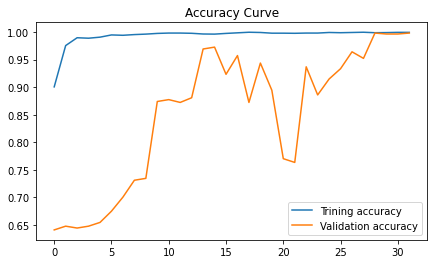

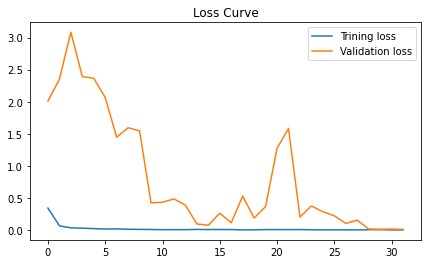

In [ ]:
### loss and accuracy curve ### updated !!!!!!!!!!

import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


fin1= pd.read_csv(r'/content/drive/MyDrive/rhd_model/csv/mobilenetv2_SE_.csv') ###directory


### accuracy curve ###
plt.figure(figsize=(7,4))
plt.plot(fin1['accuracy'], label='Trining accuracy')
plt.plot(fin1['val_accuracy'], label='Validation accuracy')

plt.title('Accuracy Curve')
plt.legend(loc='lower right')

plt.savefig(r'/content/drive/MyDrive/rhd_model/csv/Zrms_accuracy.png', dpi = 300)

### loss curve ###

plt.figure(figsize=(7,4))
plt.plot(fin1['loss'], label='Trining loss')
plt.plot(fin1['val_loss'], label='Validation loss')

plt.title('Loss Curve')

plt.savefig(r'/content/drive/MyDrive/rhd_model/csv/Zrms_loss.png', dpi = 300)
plt.legend(loc='upper right')

In [ ]:
### for f1 score and other values import files ###

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
#importing packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
### matrics
from sklearn import metrics
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
####predictions on test set

y_test=[]
probaa=[]
import os
import matplotlib.pyplot as plt
model.load_weights(r"/content/drive/MyDrive/rhd_model/h5/mobilenetv2_SE_.h5")


cls=5  #nummber of classes

## give directory of class serially..if less than 4 classes comment out the last unused dir_path
dir_path1=r'/content/drive/MyDrive/rhd_model/Furier_transform/Normal'
dir_path2=r'/content/drive/MyDrive/rhd_model/Furier_transform/Tuberculosis'
dir_path3=r'/content/drive/MyDrive/rhd_model/Furier_transform/covid19'
dir_path4=r'/content/drive/MyDrive/rhd_model/Furier_transform/pneumonia'
#dir_path5=r'D:\Inam Ullah Khan\Dataset split\val\Viral Pneumonia'



w1=0
w2=0
w3=0
w4=0


if cls==5:
  for filename in os.listdir(dir_path1):
      img=image.load_img(dir_path1+'//'+filename, target_size=(224,224,3))
      im = []
      img = image.img_to_array(img)
      img = img/255
      im.append(img)
      X= np.array(im)
      result=model.predict(X,verbose=0)
      #training_set.class_indices
      res=np.argmax(result)
      probaa.append(res)
      y_test.append(0)
      w1+=1
      print(w1,end='_')

  print('\n')
  for filename in os.listdir(dir_path2):
      img=image.load_img(dir_path2+'//'+filename, target_size=(224,224,3))
      im = []
      img = image.img_to_array(img)
      img = img/255
      im.append(img)
      X= np.array(im)
      result=model.predict(X,verbose=0)
      #training_set.class_indices
      res=np.argmax(result)
      probaa.append(res)
      y_test.append(1)
      #if res!=1: a2+=1
      w2+=1
      print(w2,end='_')

  print('\n')
  for filename in os.listdir(dir_path3):
      img=image.load_img(dir_path3+'//'+filename, target_size=(224,224,3))
      im = []
      img = image.img_to_array(img)
      img = img/255
      im.append(img)
      X= np.array(im)
      result=model.predict(X,verbose=0)
      #training_set.class_indices
      res=np.argmax(result)
      probaa.append(res)
      y_test.append(2)
      w3+=1
      print(w3,end='_')

  print('\n')
  for filename in os.listdir(dir_path4):
      img=image.load_img(dir_path4+'//'+filename, target_size=(224,224,3))
      im = []
      img = image.img_to_array(img)
      img = img/255
      im.append(img)
      X= np.array(im)
      result=model.predict(X,verbose=0)
      #training_set.class_indices
      res=np.argmax(result)
      probaa.append(res)
      y_test.append(3)
      w4+=1
      print(w4,end='_')


  print('class numbers', cls)
  print('prediction number:',len(probaa))
  print('true labels:',len(y_test))

if cls==4:
  for filename in os.listdir(dir_path1):
      img=image.load_img(dir_path1+'//'+filename, target_size=(224,224,3))
      im = []
      img = image.img_to_array(img)
      img = img/255
      im.append(img)
      X= np.array(im)
      result=model.predict(X,verbose=0)
      #training_set.class_indices
      res=np.argmax(result)
      probaa.append(res)
      y_test.append(0)
      w1+=1
      print(w1,end='_')

  print('\n')
  for filename in os.listdir(dir_path2):
      img=image.load_img(dir_path2+'//'+filename, target_size=(224,224,3))
      im = []
      img = image.img_to_array(img)
      img = img/255
      im.append(img)
      X= np.array(im)
      result=model.predict(X,verbose=0)
      #training_set.class_indices
      res=np.argmax(result)
      probaa.append(res)
      y_test.append(1)
      #if res!=1: a2+=1
      w2+=1
      print(w2,end='_')

  print('\n')
  for filename in os.listdir(dir_path3):
      img=image.load_img(dir_path3+'//'+filename, target_size=(224,224,3))
      im = []
      img = image.img_to_array(img)
      img = img/255
      im.append(img)
      X= np.array(im)
      result=model.predict(X,verbose=0)
      #training_set.class_indices
      res=np.argmax(result)
      probaa.append(res)
      y_test.append(2)
      w3+=1
      print(w3,end='_')

  print('\n')
  for filename in os.listdir(dir_path4):
      img=image.load_img(dir_path4+'//'+filename, target_size=(224,224,3))
      im = []
      img = image.img_to_array(img)
      img = img/255
      im.append(img)
      X= np.array(im)
      result=model.predict(X,verbose=0)
      #training_set.class_indices
      res=np.argmax(result)
      probaa.append(res)
      y_test.append(3)
      w4+=1
      print(w4,end='_')

  print('class numbers', cls)
  print('prediction number:',len(probaa))
  print('true labels:',len(y_test))


if cls==2:
  for filename in os.listdir(dir_path1):
      img=image.load_img(dir_path1+'//'+filename, target_size=(224,224,3))
      im = []
      img = image.img_to_array(img)
      img = img/255
      im.append(img)
      X= np.array(im)
      result=model.predict(X,verbose=0)
      #training_set.class_indices
      res=np.argmax(result)
      probaa.append(res)
      y_test.append(0)
      w1+=1
      print(w1,end='_')

  print('\n')
  for filename in os.listdir(dir_path2):
      img=image.load_img(dir_path2+'//'+filename, target_size=(224,224,3))
      im = []
      img = image.img_to_array(img)
      img = img/255
      im.append(img)
      X= np.array(im)
      result=model.predict(X,verbose=0)
      #training_set.class_indices
      res=np.argmax(result)
      probaa.append(res)
      y_test.append(1)
      #if res!=1: a2+=1
      w2+=1
      print(w2,end='_')

  print('\n')

  print('class numbers', cls)
  print('prediction number:',len(probaa))
  print('true labels:',len(y_test))


if cls==3:
  for filename in os.listdir(dir_path1):
      img=image.load_img(dir_path1+'//'+filename, target_size=(224,224,3))
      im = []
      img = image.img_to_array(img)
      img = img/255
      im.append(img)
      X= np.array(im)
      result=model.predict(X,verbose=0)
      #training_set.class_indices
      res=np.argmax(result)
      probaa.append(res)
      y_test.append(0)
      w1+=1
      print(w1,end='_')

  print('\n')
  for filename in os.listdir(dir_path2):
      img=image.load_img(dir_path2+'//'+filename, target_size=(224,224,3))
      im = []
      img = image.img_to_array(img)
      img = img/255
      im.append(img)
      X= np.array(im)
      result=model.predict(X,verbose=0)
      #training_set.class_indices
      res=np.argmax(result)
      probaa.append(res)
      y_test.append(1)
      w2+=1
      print(w2,end='_')

  print('\n')
  for filename in os.listdir(dir_path3):
      img=image.load_img(dir_path3+'//'+filename, target_size=(224,224,3))
      im = []
      img = image.img_to_array(img)
      img = img/255
      im.append(img)
      X= np.array(im)
      result=model.predict(X,verbose=0)
      #training_set.class_indices
      res=np.argmax(result)
      probaa.append(res)
      y_test.append(2)
      w3+=1
      print(w3,end='_')

  print('\n')

  print('class numbers', cls)
  print('prediction number:',len(probaa))
  print('true labels:',len(y_test))

1_2_3_4_5_6_7_8_9_10_11_12_13_14_15_16_17_18_19_20_21_22_23_24_25_26_27_28_29_30_31_32_33_34_35_36_37_38_39_40_41_42_43_44_45_46_47_48_49_50_51_52_53_54_55_56_57_58_59_60_61_62_63_64_65_66_67_68_69_70_71_72_73_74_75_76_77_78_79_80_81_82_83_84_85_86_87_88_89_90_91_92_93_94_95_96_97_98_99_100_101_102_103_104_105_106_107_108_109_110_111_112_113_114_115_116_117_118_119_120_121_122_123_124_125_126_127_128_129_130_131_132_133_134_135_136_137_138_139_140_141_142_143_144_145_146_147_148_149_150_151_152_153_154_155_156_157_158_159_160_161_162_163_164_165_166_167_168_169_170_171_172_173_174_175_176_177_178_179_180_181_182_183_184_185_186_187_188_189_190_191_192_193_194_195_196_197_198_199_200_201_202_203_204_205_206_207_208_209_210_211_212_213_214_215_216_217_218_219_220_221_222_223_224_225_226_227_228_229_230_231_232_233_234_235_236_237_238_239_240_241_242_243_244_245_246_247_248_249_250_251_252_253_254_255_256_257_258_259_260_261_262_263_264_265_266_267_268_269_270_271_272_273_274_275_276_277_

In [ ]:
#We use Support Vector classifier as a classifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
#importing packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
### matrics
from sklearn import metrics
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

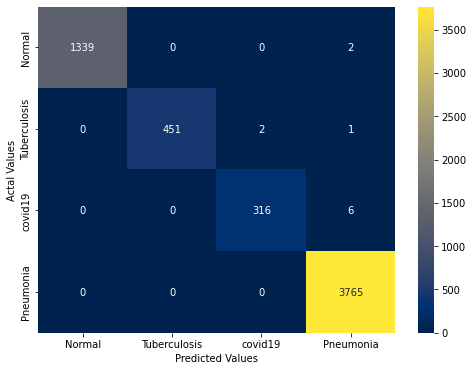

In [ ]:
##  make a directory for storing figures
y_preD=probaa
cm = confusion_matrix(y_test, y_preD)
cm_df = pd.DataFrame(cm,
                     index = ['Normal','Tuberculosis','covid19','Pneumonia'],
                     columns = ['Normal','Tuberculosis','covid19','Pneumonia'])

#Plotting the confusion matrix

#import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
sns.heatmap(cm_df,cmap='cividis', annot=True, fmt='d')
#plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')

###save confusion matrix to fig directory ...keep the image file name as h5 file name. ex:  breastCancer_geometric.h5 >>> breastCancer_geometric_con.png
plt.savefig("/content/drive/MyDrive/rhd_model/csv/confusion_matrix.png", dpi = 300)
plt.show()


In [ ]:
y_preD=probaa
y_val=y_test

confusion_matrix=cm

FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = len(y_val) - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP)
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)


from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math
from numpy import mean

MAE=mean_absolute_error(y_val, y_preD)
MSE=mean_squared_error(y_val, y_preD)
F1=2*((mean(PPV)*mean(TPR))/(mean(PPV)+mean(TPR)))

#print("ACC=   ",mean(ACC)*100)

print("Rec=   ",mean(TPR)*100)
print("Spe=   ",mean(TNR)*100)
print("Pre=   ",mean(PPV)*100)
print("FPR=   ",mean(FPR)*100)
print("FNR=   ",mean(FNR)*100)
print("NPV=   ",mean(NPV)*100)
print("FDR=   ",mean(FDR)*100)
print("F1=    ",mean(F1)*100)

print("MAE   =",MAE*100)
print("RMSE  =",math.sqrt(MSE)*100)




Rec=    99.33167764504236
Spe=    99.88472471904385
Pre=    99.78314885362612
FPR=    0.11527528095615146
FNR=    0.6683223549576391
NPV=    99.94822542301495
FDR=    0.21685114637389888
F1=     99.55690141840793
MAE   = 0.27201632097925876
RMSE  = 7.1416426810371165
